## Price movement from 2:00PM to 2:30PM

In [87]:
# Idea
# Khoang cach(bar) tu cay nen 2h den cay nen cao nhat va thap nhat trong ngay(2 cases: truoc va sau 2h)
# Percent price giua gia luc 2h va gia cao nhat, thap nhat trong ngay
# Su phu thuoc cua return vao 2 yeu to tren

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [89]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [90]:
data = dataset.copy()

In [91]:
def cal_first_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 915]
  if not tick.empty:
    return tick[0]


def cal_high_before(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1355]
  return tick.max()

def cal_high_after(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1355]
  tick = tick[100*tick.index.hour+tick.index.minute < 1430]
  return tick.max()


def cal_low_before(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1355]
  return tick.min()


def cal_low_after(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1355]
  tick = tick[100*tick.index.hour+tick.index.minute < 1430]
  return tick.min()


def cal_price(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1355]
  if not tick.empty:
    return tick[0]

def cal_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1425]
  if not tick.empty:
    return tick[0]
      
def cal_last(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1445]
  if not tick.empty:
    return tick[0]

In [92]:
data['first_close'] = data.Close
data['price'] = data.Close
data['Day_Close'] = data.Close
data['prev_high'] = data.High
data['prev_low'] = data.Low
data['next_high'] = data.High
data['next_low'] = data.Low
day_data = data.resample("D").agg({
    'first_close': cal_first_close,
    'prev_high':cal_high_before,
    'prev_low': cal_low_before,
    'next_high':cal_high_after,
    'next_low': cal_low_after,
    'price': cal_price,
    'Close': cal_close,
    'Day_Close': cal_last
    })
day_data = day_data.dropna()

In [93]:
day_data

,first_close,prev_high,prev_low,next_high,next_low,price,Close,Day_Close
Date,,,,,,,,
2018-08-14,956.9,958.6,952.1,961.8,959.0,959.5,960.1,959.3
2018-08-15,960.7,962.3,954.7,959.3,949.9,959.2,951.2,946.6
2018-08-16,942.1,943.5,935.5,947.3,942.6,943.0,944.5,947.0
2018-08-17,953.2,954.6,946.4,949.9,945.0,946.5,947.0,947.0
2018-08-20,946.1,951.5,944.1,946.5,942.6,946.5,944.7,945.0
...,...,...,...,...,...,...,...,...
2024-07-15,1303.4,1305.6,1298.7,1299.8,1292.7,1299.9,1297.0,1299.0
2024-07-16,1301.6,1308.7,1300.3,1304.1,1299.1,1303.1,1301.8,1302.7
2024-07-17,1308.5,1315.5,1301.7,1321.8,1294.7,1314.0,1296.9,1303.2


In [94]:
len(day_data[(day_data.next_high - day_data.price > 0) & (day_data.price - day_data.next_low > 0)])

1336

In [95]:
len(day_data[(day_data.next_high - day_data.price > 3) & (day_data.price - day_data.next_low > 3)])

222

In [96]:
price = day_data

In [97]:
# mom_y = momentum_yesterday
price['mom_y'] = 100 * (price.price - price.Day_Close.shift(1)) / price.Day_Close.shift(1)
price['body_rate'] = (price.price - price.first_close) / (price.prev_high - price.prev_low)
price['return'] = 1000 * (price.Close - price.price) / price.price
# price['next_high_rate'] = 1000 * (price.next_high - price.price) / price.price
# price['next_low_rate'] = 1000 * (price.next_low - price.price) / price.price

In [98]:
data_test = price[price.index > '2024-01-01 00:00:00']

In [99]:
### Ignore this year data => tranh over fitting
price = price[price.index < '2024-01-01 00:00:00']

### Estimated return - distribution

In [100]:
price['return'].describe()

count    1332.000000
mean       -0.182972
std         5.976855
min       -25.482943
25%        -2.813928
50%         0.154657
75%         2.775381
max        29.089314
Name: return, dtype: float64

In [101]:
price['return_group'] = pd.cut(price['return'], 30)
r1 = price.groupby(['return_group'])[['return']].count()
r11 = r1[['return']].rename(columns={'return': 'count'})
r11

,count
return_group,
"(-25.538, -23.664]",2
"(-23.664, -21.845]",2
"(-21.845, -20.026]",4
"(-20.026, -18.207]",5
"(-18.207, -16.388]",7
"(-16.388, -14.568]",13
"(-14.568, -12.749]",12
"(-12.749, -10.93]",16
"(-10.93, -9.111]",16


In [102]:
# Think about drop the outlier data
price = price[(price['return'] > -20) & (price['return'] < 15)]

### Body rate - distribution

In [103]:
price['body_rate'].describe()

count    1310.000000
mean       -0.001205
std         0.540358
min        -1.537037
25%        -0.459411
50%         0.018188
75%         0.456105
max         1.390244
Name: body_rate, dtype: float64

In [104]:
price['body_rate_group'] = pd.qcut(price.body_rate, 30)

### Momentum today-yesterday - distribution

In [105]:
price['mom_y'].describe()

count    1309.000000
mean        0.044658
std         1.280470
min       -10.381944
25%        -0.398906
50%         0.073253
75%         0.603318
max         9.806157
Name: mom_y, dtype: float64

In [106]:
price['mom_y_group'] = pd.qcut(price.mom_y, 20)

### Regplot

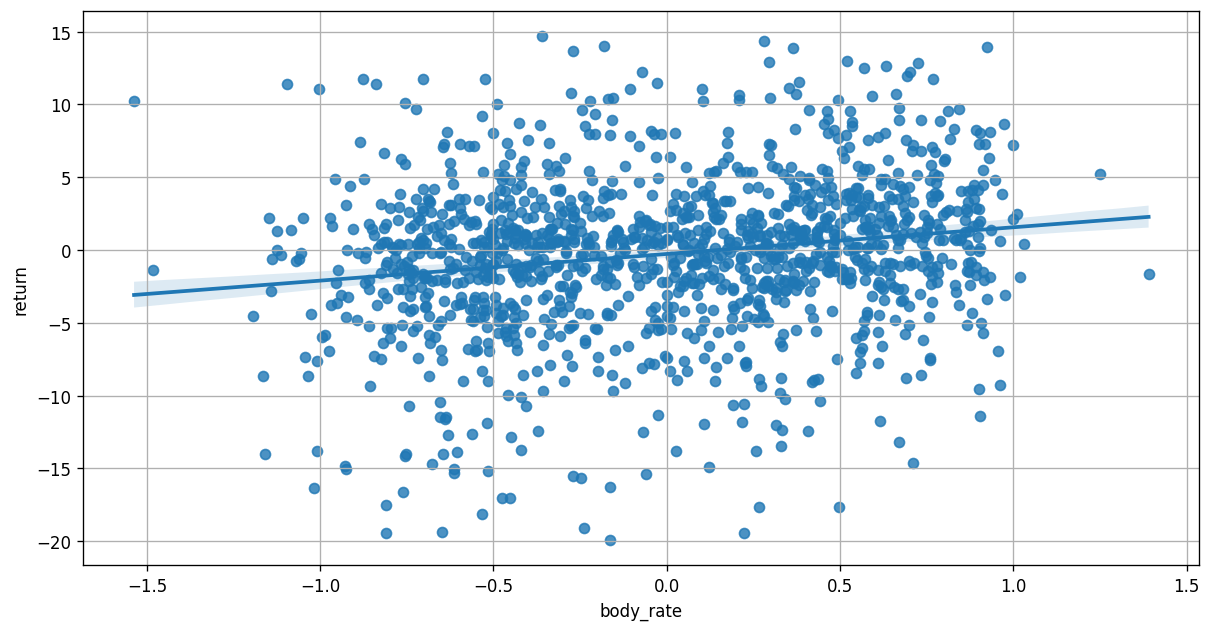

In [107]:
sns.regplot(x=price['body_rate'], y=price['return'])
plt.grid(True)

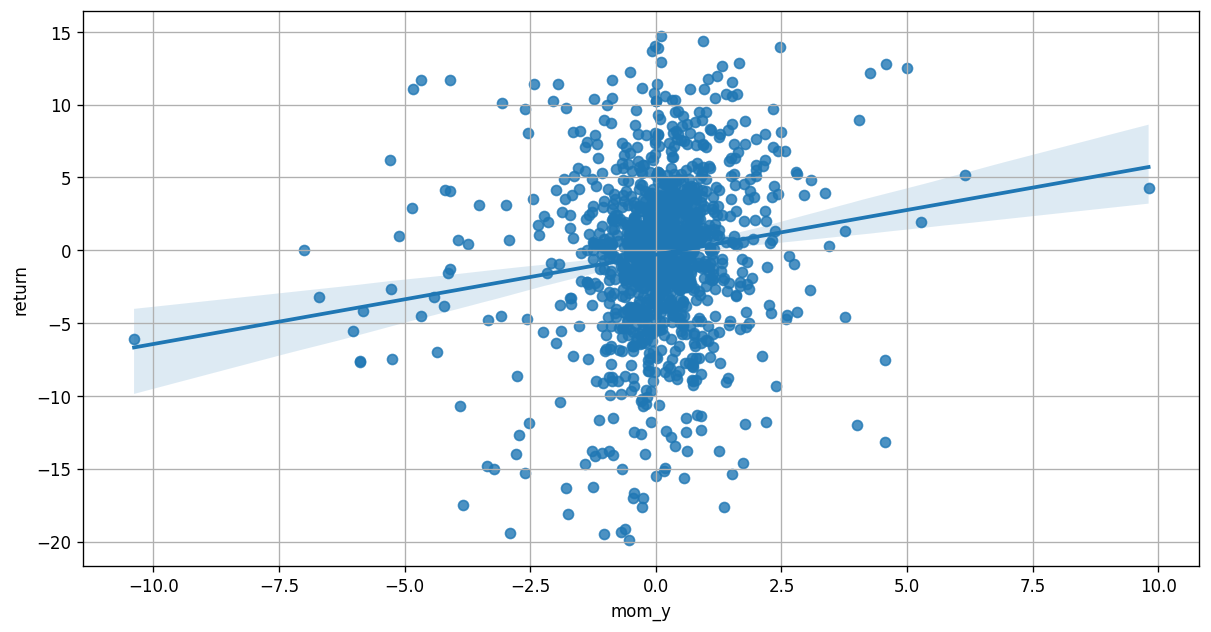

In [108]:
sns.regplot(x=price['mom_y'], y=price['return'])
plt.grid(True)

### Heatmap

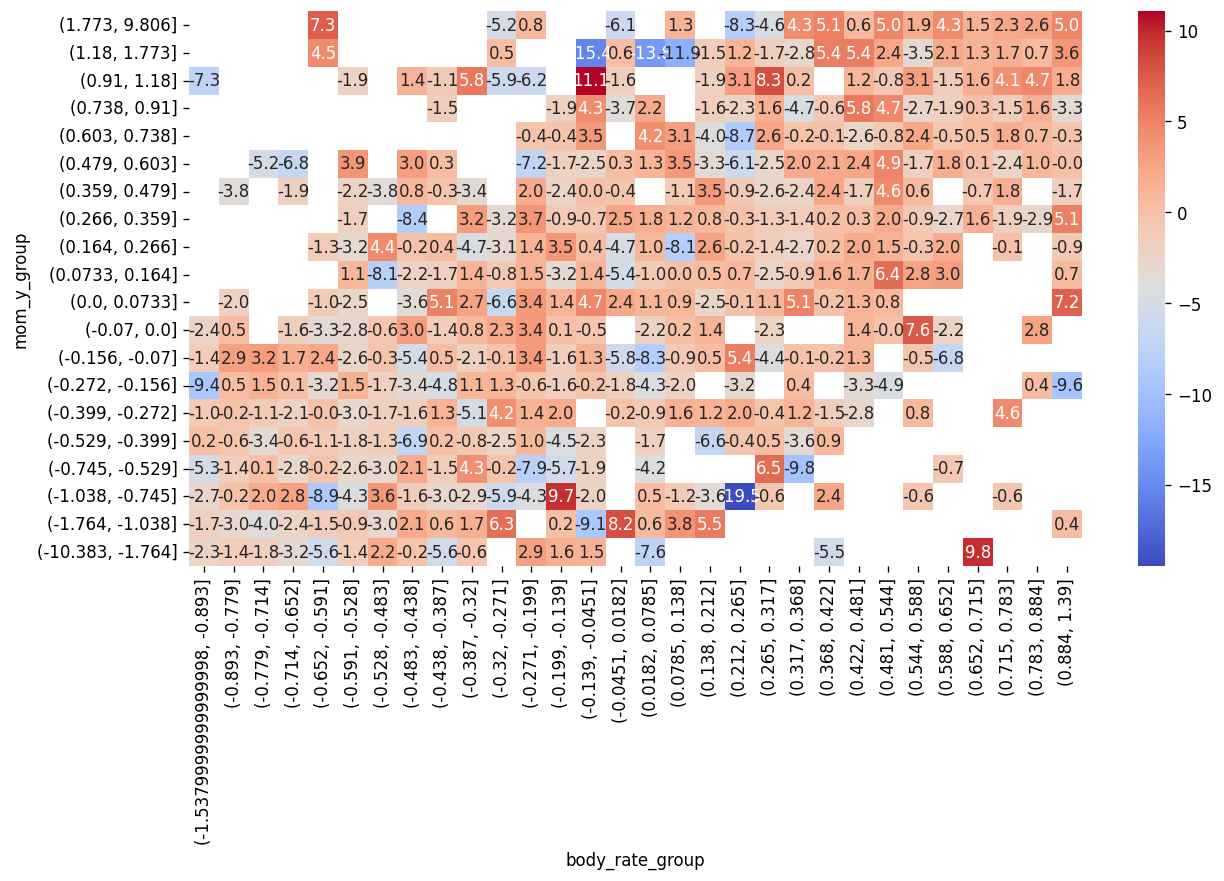

In [109]:
grpd = price.groupby(['mom_y_group', 'body_rate_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='mom_y_group', columns='body_rate_group', values='return').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True, fmt=".1f");

In [134]:
L = price[(price.mom_y > 0) & (price.body_rate > .36)]

In [135]:
L['return'].sum()

509.85790386492283

In [121]:
L['low_diff'] = L['price'] - L['next_low']

In [128]:
L['low_diff'].describe()

count    384.000000
mean       3.111458
std        3.644377
min       -0.300000
25%        0.700000
50%        1.950000
75%        4.300000
max       27.000000
Name: low_diff, dtype: float64

In [136]:
S = price[(price.mom_y < 0.48) & (price.body_rate < .3)]

In [137]:
S['return'].sum()

-680.146314730039

In [125]:
S['high_diff'] = S['next_high'] - S['price']

In [129]:
S['high_diff'].describe()

count    661.000000
mean       3.688048
std        4.119965
min       -1.000000
25%        1.000000
50%        2.300000
75%        4.800000
max       27.300000
Name: high_diff, dtype: float64

In [117]:
Long = data_test[(data_test.mom_y > 0) & (data_test.body_rate > .31)]
Long

,first_close,prev_high,prev_low,next_high,next_low,price,Close,Day_Close,mom_y,body_rate,return
Date,,,,,,,,,,,
2024-01-03,1127.7,1136.8,1126.5,1142.1,1134.4,1136.2,1142.1,1148.3,0.238200,0.825243,5.192748
2024-01-04,1147.4,1170.0,1145.5,1171.0,1158.0,1167.4,1159.5,1156.5,1.663328,0.816327,-6.767175
2024-01-18,1169.0,1175.5,1165.8,1177.8,1172.3,1175.9,1172.9,1172.8,0.849057,0.711340,-2.551237
2024-01-30,1183.7,1185.0,1182.7,1187.2,1183.6,1184.5,1187.2,1186.0,0.076039,0.347826,2.279443
2024-02-01,1170.8,1180.5,1168.6,1179.6,1175.9,1177.5,1177.7,1177.2,0.555081,0.563025,0.169851
2024-02-05,1181.9,1195.8,1181.3,1211.0,1202.1,1202.9,1203.9,1202.5,1.845737,1.448276,0.831324
2024-02-07,1206.9,1216.9,1205.3,1219.8,1216.5,1217.2,1217.2,1219.0,1.104743,0.887931,0.000000
2024-02-15,1222.6,1226.8,1219.5,1227.8,1218.0,1226.4,1218.1,1217.8,0.607055,0.520548,-6.767776
2024-02-19,1233.5,1239.0,1230.6,1243.6,1237.2,1238.9,1243.4,1240.5,0.560065,0.642857,3.632254


In [118]:
Long['return'].sum()

-0.24565210027566842